In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Load data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
data = pd.read_csv("raw_combined_2.csv") 

# get the length of section
print("Total number of texts: ", len(data['text']))
print("Total number of labels: ", len(data['label']))

#get unique labels
unique_labels = list(set(data['label']))
print("The unique labels are: ", unique_labels)

Total number of texts:  1998
Total number of labels:  1998
The unique labels are:  [0, 1]


In [19]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in split1.split(data, data['label']):
    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]

# Second split: 60% train and 20% validation from 80% train+val
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in split2.split(train_val_data, train_val_data['label']):
    train_data = train_val_data.iloc[train_idx]
    val_data = train_val_data.iloc[val_idx]

# Verify the splits on the labels
print("Train data: ", train_data['label'].value_counts(normalize=False))
print("Validation data: ", val_data['label'].value_counts(normalize=False))
print("Test data: ", test_data['label'].value_counts(normalize=False))

Train data:  label
0    664
1    534
Name: count, dtype: int64
Validation data:  label
0    222
1    178
Name: count, dtype: int64
Test data:  label
0    222
1    178
Name: count, dtype: int64


In [11]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_dataset = Dataset.from_dict(train_data.to_dict(orient='list'))
val_dataset = Dataset.from_dict(val_data.to_dict(orient='list'))
test_dataset = Dataset.from_dict(test_data.to_dict(orient='list'))

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
model = model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()

Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/114 [00:00<?, ?it/s]

{'loss': 0.5888, 'grad_norm': 2.0406720638275146, 'learning_rate': 1.824561403508772e-05, 'epoch': 0.26}
{'loss': 0.283, 'grad_norm': 1.6255041360855103, 'learning_rate': 1.649122807017544e-05, 'epoch': 0.53}
{'loss': 0.1351, 'grad_norm': 2.4084293842315674, 'learning_rate': 1.4736842105263159e-05, 'epoch': 0.79}


  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 0.9950
Precision: 0.9950
Recall: 0.9950
F1 Score: 0.9950


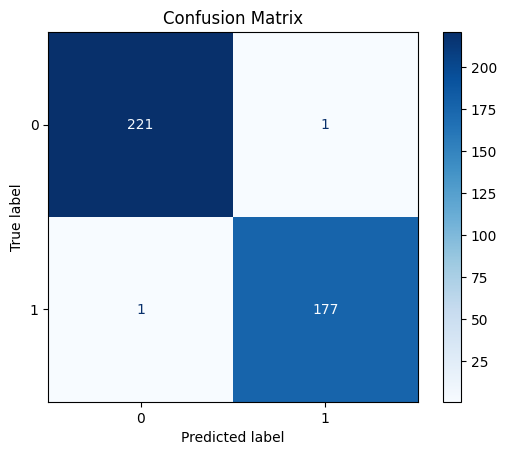

In [ ]:
# Predict on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)  # Predicted class
true_labels = predictions.label_ids  # True labels

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Replace unique_labels with your label names
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Second fine-tuning

In [5]:
waste_data = pd.read_csv("New_Data/waste_data.csv")

# get the length of section
print("Total number of texts: ", len(waste_data['text']))
print("Total number of labels: ", len(waste_data['label']))

#get number of papers per label
print("The number of papers per label are: ", waste_data['label'].value_counts(normalize=False))


Total number of texts:  12
Total number of labels:  12
The number of papers per label are:  label
1    10
0     2
Name: count, dtype: int64


In [9]:
# Separate the data by label
label_1_data = waste_data[waste_data['label'] == 1]
label_0_data = waste_data[waste_data['label'] == 0]

# Assign 7 papers with label 1 and 1 paper with label 0 to the train set
waste_train_data = pd.concat([label_1_data.iloc[:7], label_0_data.iloc[:1]])

# Assign the remaining data to the validation set
waste_val_data = pd.concat([label_1_data.iloc[7:], label_0_data.iloc[1:]])

# Print the resulting splits
print("\nTrain Data:")
print(waste_train_data['label'].value_counts())
print("\nValidation Data:")
print(waste_val_data['label'].value_counts())


Train Data:
label
1    7
0    1
Name: count, dtype: int64

Validation Data:
label
1    3
0    1
Name: count, dtype: int64


In [ ]:
waste_train_dataset = Dataset.from_dict(waste_train_data.to_dict(orient='list'))
waste_val_dataset = Dataset.from_dict(waste_val_data.to_dict(orient='list'))


# Apply tokenization
waste_train_dataset = waste_train_dataset.map(tokenize_function, batched=True)
waste_val_dataset = waste_val_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
waste_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
waste_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
waste_model = waste_model.to(device)
# Training arguments
waste_training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=13,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
waste_trainer = Trainer(
    model=waste_model,
    args=waste_training_args,
    train_dataset=waste_train_dataset,
    eval_dataset=waste_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
waste_trainer.train()

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/13 [00:00<?, ?it/s]